# 9428 Aromin - Encarnacion

### Data Exploration and Preprocessing

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset
df = pd.read_csv('productsales.csv', parse_dates=['date'])
print("Data head:\n", df.head())
print("\nData info:\n", df.info())

# Aggregate total daily sales (across all stalls and products)
daily_sales = df.groupby('date')['number_sold'].sum().reset_index()
daily_sales.set_index('date', inplace=True)
daily_sales = daily_sales.asfreq('D').fillna(0)  # Handle missing dates

print("\nDaily sales head:\n", daily_sales.head())

Data head:
    stall_id  product_type       date  number_sold
0         0             0 2010-01-01          801
1         0             0 2010-01-02          810
2         0             0 2010-01-03          818
3         0             0 2010-01-04          796
4         0             0 2010-01-05          808
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255640 entries, 0 to 255639
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   stall_id      255640 non-null  int64         
 1   product_type  255640 non-null  int64         
 2   date          255640 non-null  datetime64[ns]
 3   number_sold   255640 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 7.8 MB

Data info:
 None

Daily sales head:
             number_sold
date                   
2010-01-01        54870
2010-01-02        54960
2010-01-03        54863
2010-01-04        54926
2010-01-05        54634


### Exploratory Data Analysis


KEY PERFORMANCE ANALYSIS
TOP PRODUCT: Product 7
  - Total sales: 21,293,947 units
  - Percentage of total sales: 10.7%

--------------------------------------------------
WORST STALL: Stall 3
  - Total sales: 12,566,763 units
  - Percentage of total sales: 6.3%


<Figure size 1200x600 with 0 Axes>

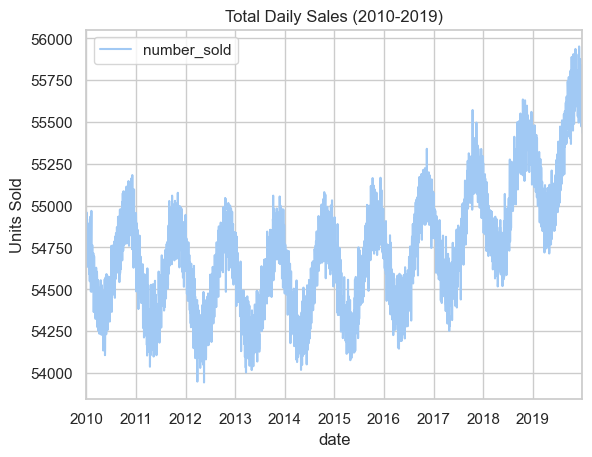

ADF Statistic: -2.500
p-value: 0.115
Non-Stationary


In [16]:
product_sales = df.groupby('product_type')['number_sold'].sum()
stall_sales = df.groupby('stall_id')['number_sold'].sum()
top_product = product_sales.idxmax()
worst_stall = stall_sales.idxmin()

# Display results
print("\n" + "="*50)
print("KEY PERFORMANCE ANALYSIS")
print("="*50)
print(f"TOP PRODUCT: Product {top_product}")
print(f"  - Total sales: {product_sales.max():,} units")
print(f"  - Percentage of total sales: {product_sales.max()/product_sales.sum()*100:.1f}%")
print("\n" + "-"*50)
print(f"WORST STALL: Stall {worst_stall}")
print(f"  - Total sales: {stall_sales.min():,} units")
print(f"  - Percentage of total sales: {stall_sales.min()/stall_sales.sum()*100:.1f}%")
print("="*50)

# Plot daily sales
plt.figure(figsize=(12, 6))
daily_sales.plot(title='Total Daily Sales (2010-2019)')
plt.ylabel('Units Sold')
plt.show()

# Stationarity test (AD Fuller)
def test_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Stationary' if result[1] < 0.05 else 'Non-Stationary')

test_stationarity(daily_sales['number_sold'])

### Model Training and Evaluation Metrics

ADF Statistic: -6.985
p-value: 0.000
Stationary


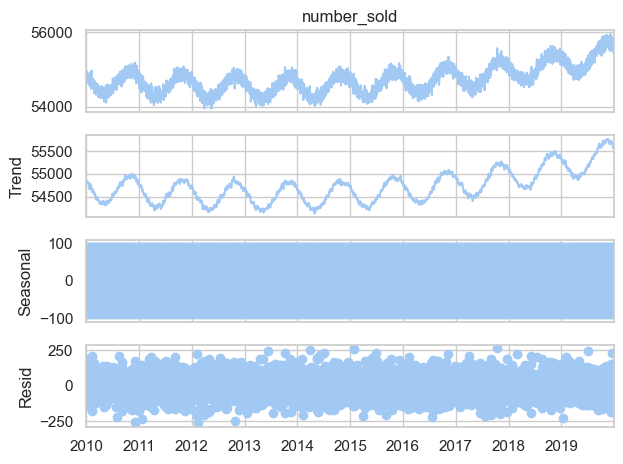

In [17]:
# Apply differencing (1st order) and seasonal decomposition
daily_sales['diff_1'] = daily_sales['number_sold'].diff().dropna()
test_stationarity(daily_sales['diff_1'].dropna())

# Decomposition (weekly seasonality)
decomposition = seasonal_decompose(daily_sales['number_sold'], period=7)
decomposition.plot()
plt.show()

<Figure size 1200x800 with 0 Axes>

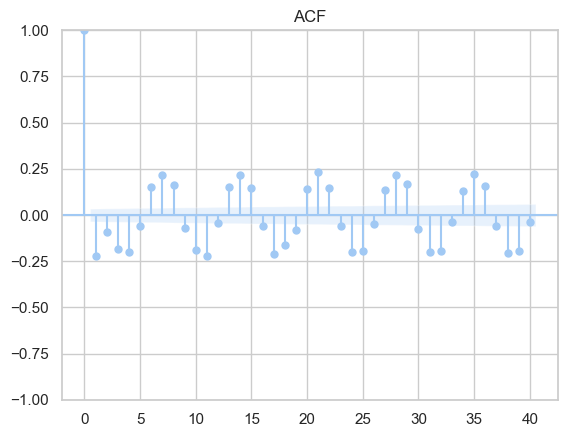

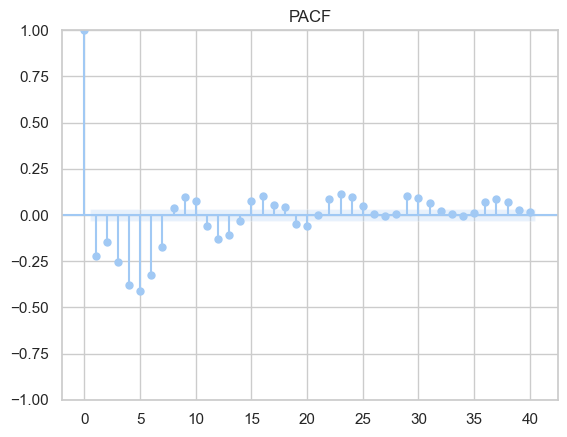

                                     SARIMAX Results                                     
Dep. Variable:                       number_sold   No. Observations:                 3287
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -19429.804
Date:                           Mon, 07 Jul 2025   AIC                          38869.608
Time:                                   17:22:10   BIC                          38900.085
Sample:                               01-01-2010   HQIC                         38880.521
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0122      0.019     -0.634      0.526      -0.050       0.025
ma.L1         -0.8030      0.013    -61.979

In [18]:
# Train/Test Split
train = daily_sales.loc['2010-01-01':'2018-12-31']
test = daily_sales.loc['2019-01-01':'2019-12-31']

# Identify SARIMA parameters (using ACF/PACF)
plt.figure(figsize=(12, 8))
plot_acf(train['diff_1'].dropna(), lags=40, title='ACF')
plot_pacf(train['diff_1'].dropna(), lags=40, title='PACF')
plt.show()

# Fit SARIMA(1,1,1)(1,1,1,7)
model = SARIMAX(train['number_sold'], order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit(disp=False)
print(results.summary())

In [19]:
# Forecast for 2019
forecast = results.get_forecast(steps=len(test))
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# Calculate metrics
mae = mean_absolute_error(test['number_sold'], pred)
rmse = np.sqrt(mean_squared_error(test['number_sold'], pred))
mape = np.mean(np.abs((test['number_sold'] - pred) / test['number_sold'])) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 258.59
RMSE: 297.04
MAPE: 0.47%


### Visualization

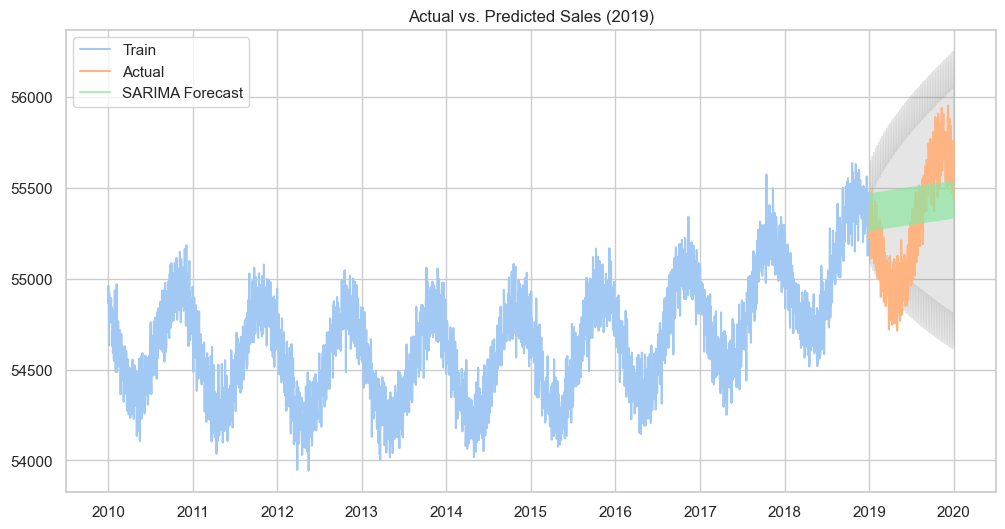

In [20]:
# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['number_sold'], label='Train')
plt.plot(test.index, test['number_sold'], label='Actual')
plt.plot(test.index, pred, label='SARIMA Forecast', alpha=0.7)
plt.fill_between(test.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='gray', alpha=0.2)
plt.title('Actual vs. Predicted Sales (2019)')
plt.legend()
plt.show()